# 4.5.1 Unsupervised Learning Capstone

1. Pick a set of texts, - at least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import spacy
from collections import Counter

import re
from sklearn.model_selection import train_test_split

import xml.etree.ElementTree as ET
import os
from time import time

## Exploring corpora to use for this project

The following corpora are from the [University of Oxford Text Archive](https://ota.ox.ac.uk/) :
* 2518 is [The Electronic Text Corpus of Sumerian Literature. Revised edition](https://ota.ox.ac.uk/desc/2518)
* 2554 is [British National Corpus](https://ota.ox.ac.uk/desc/2554)

There is also a corpus of blog entries: [Blog Authorship Corpus](https://u.cs.biu.ac.il/~koppel/BlogCorpus.htm)


In [2]:
path_s = '/Users/gemma/Documents/data science/2518_from_oxford/2518/etcsl/translations/'

files_s = os.listdir(path_s)

In [3]:
path_BNC = '/Users/gemma/Documents/data science/2554_from_oxford/2554/download/Texts/'

# levels are:  download/ Texts / 1 letter /  2 letters / XML files

one_letter = os.listdir(path_BNC)

filenames_BNC = []

for i, letter in enumerate(one_letter):
    # ignore the .DS_store file 
    if one_letter[i][0] != '.':
        two_letters = os.listdir(path_BNC+letter+'/')

        for pair in two_letters:
            if pair[0] != '.': # ignore the .DS_store file again
                all_files = os.listdir(path_BNC+letter+'/'+pair+'/')
                
                for file in all_files:
                    filenames_BNC.append(path_BNC+letter+'/'+pair+'/'+file)
        

After taking a look at the Sumerian translations, it seems like the text is fragmented and as a result may be difficult to parse.

The BNC covers many different topics and that won't fulfill the requirements of this project.

Looking at the blog posts, let's first get the file path and create a list of the filenames to read in from.

# Part 1 - Getting and organizing the data

In [4]:
path_blogs = '/Users/gemma/Documents/data science/blogs/'
blog_files = os.listdir(path_blogs)

In [5]:
# looking at the structure of the filename
blog_files[2]

'3954575.female.23.BusinessServices.Gemini.xml'

Let's see how many blogs we're working with:

In [6]:
len(blog_files)

19320

Next, I'll try to read one blog in and take a look at the structure inside the file.

In [7]:
#file = filenames_BNC[5]   # the BNC

file = path_blogs+blog_files[3] # blogs

#file = path_s+files_s[0]   # sumerian texts

print(file)

# parse the tree and get the root to iterate from later

tree = ET.parse(file)
root = tree.getroot()

/Users/gemma/Documents/data science/blogs/3364931.male.16.Student.Virgo.xml


It looks like there is an issue parsing in the file to the tree due to the character <code>& nbsp;</code>. Let's go through the files, replace all the <code>& nbsp;</code>s with spaces, and then see if it'll work.

Some useful info on reading in files in general and the different modes you can read them in / write them in: [here](https://www.guru99.com/reading-and-writing-files-in-python.html#3).

Also info about how to make the tree from a string was found on [stack overflow](https://stackoverflow.com/questions/647071/python-xml-elementtree-from-a-string-source).

In [8]:
def file_to_string(filename):
    
    f=open(filename, "r") #open the file in read mode. don't change it2 write, otherwise... :D

    if f.mode == 'r': # double check that it's in read mode
        text = f.read() # read the file to the text
    
    space = re.compile('&nbsp;') # this was preventing it from parsing straight from the file
    text = re.sub(space, " ", text) # sub the problem char out with a space
    
    #sometimes & is used as and or is just in the text - accounting for those situations
    
    andd = re.compile('& ')
    text = re.sub(andd, "and ", text) #
    
    randomand = re.compile('&')
    text = re.sub(randomand, "", text)
    
    ugh = re.compile('<>')
    text = re.sub(ugh, "", text)
    
    face = re.compile('>.<')
    text = re.sub(face, "", text)
    
    return text

Let's take a look at all of the elements in the tree.

In [9]:
set([elem.tag for elem in root.iter()])

# another way to look at the structure of the doc: 

#for thing in root.getiterator():
#    print(thing)

{'Blog', 'date', 'post'}

Next, in order to create the dataframe, let's create a function to get the data out of each xml file that has been parsed to a string with the function defined above.

Let's also use the previously used text cleaner function to clean up the text in each post.

In [10]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [11]:
# before using this function, i'll have to remember to define the 3 lists 

def split_data(filename, dates, posts, authors):

    file_as_text = file_to_string(path_blogs+filename)
    #file_as_text = file_to_string(filename)
        
    # since we are going to get the tree from a string and not a file 
    # we can't use ET.parse, and will use the following
    
    tree = ET.ElementTree(ET.fromstring(file_as_text))
    root = tree.getroot()

    for post_date in root.findall('date'):
        
        # replace the , with . so the structure is consistent
        date_split = re.sub(r",", "-", post_date.text)
        dates.append(date_split)
        
        authors.append(filename)
        
    for post_itself in root.findall('post'):
        
        cleaned = text_cleaner(post_itself.text)
        posts.append(cleaned)
    
    return 

We'll pick 250 files randomly to try to read in data from, to use in the dataframe. Then we'll have extra files in case a significant amount of them have errors and can't be read in on a first try. 

In [82]:
selected = np.random.choice(blog_files,250)

<em>Info about error handling from [here](https://docs.python.org/3/tutorial/errors.html)</em>

In [83]:
# the lists (and 1 dict) are 

dates = []
posts = []
authors = []

count = 0

for i, file in enumerate(selected):
    try:
        split_data(file, dates, posts, authors)    
    except:
        #UnicodeDecodeError:
        print('Error with {}'.format(i))
        count+=1
    
print('error count = {}'.format(count))

Error with 0
Error with 2
Error with 3
Error with 4
Error with 5
Error with 6
Error with 9
Error with 13
Error with 14
Error with 17
Error with 23
Error with 29
Error with 31
Error with 37
Error with 39
Error with 40
Error with 44
Error with 46
Error with 47
Error with 48
Error with 51
Error with 55
Error with 57
Error with 61
Error with 62
Error with 67
Error with 68
Error with 70
Error with 73
Error with 75
Error with 77
Error with 78
Error with 79
Error with 81
Error with 82
Error with 90
Error with 91
Error with 96
Error with 100
Error with 102
Error with 103
Error with 107
Error with 112
Error with 115
Error with 116
Error with 121
Error with 123
Error with 125
Error with 127
Error with 128
Error with 129
Error with 133
Error with 137
Error with 138
Error with 141
Error with 143
Error with 144
Error with 150
Error with 154
Error with 158
Error with 161
Error with 162
Error with 163
Error with 169
Error with 174
Error with 176
Error with 182
Error with 183
Error with 187
Error with

In [84]:
# make a dictionary from authors to create the dataframe from there

author_dict = {}

for i, value in enumerate(authors):
    separated = value.split(".")
    author_dict[i] = separated[:-1]


In [85]:
df = pd.DataFrame.from_dict(data=author_dict, orient='index', columns=['author_id', 'gender', 
                                                       'age', 'industry', 'sign'] )

df['date'] = dates
df['post'] = posts

In [86]:
df.head()

,author_id,gender,age,industry,sign,date,post
0,3537375,male,23,Student,Leo,25-June-2004,"It was going to be a boring, depressing (See b..."
1,3537375,male,23,Student,Leo,23-June-2004,It seems that RIAA has once again cranked up t...
2,3537375,male,23,Student,Leo,22-June-2004,Am I the only one who'd like to know what the ...
3,3537375,male,23,Student,Leo,18-June-2004,"As the link will show, the number one selling ..."
4,3537375,male,23,Student,Leo,15-June-2004,urlLink Supreme Court Ruling The Court nicely ...


After separating and re combining the data into the dataframe, I'll use spacy to parse the blog posts.

In [87]:
nlp = spacy.load('en_core_web_lg')

df['parsed'] = df['post'].apply(nlp)

I found that some of the months are not in English, which leads to the assumption that some of the posts are not in English. Originally I just replaced the months with the english but the analysis of the text won't work since we are only loading the English language.

I'll use Google Cloud API to check the language of each row, and then drop rows that aren't in English. I used these resources: [Translation API Client Libraries](https://cloud.google.com/translate/docs/reference/libraries) (and [explicitly adding credentials](https://cloud.google.com/docs/authentication/production)) and [Detecting the lang of a string](https://cloud.google.com/translate/docs/detecting-language#translate_detect_language-python) . 

Another resource - [lang detect](https://pypi.org/project/langdetect/).

In [88]:
#export GOOGLE_APPLICATION_CREDENTIALS="""/Users/gemma/Documents/data science/DS Bootcamp/
#                                         My First Project-901fbdcc624d.json"""

# Imports the Google Cloud client library
from google.cloud import translate

# Instantiates a client
translate_client = translate.Client.from_service_account_json(
        '/Users/gemma/Documents/data science/DS Bootcamp/My First Project-901fbdcc624d.json')


In [89]:
# running this on the whole sries made me hit the quota on the79th row, so im
# just going to look at the first 50 char of each post

def check_fifty_char(series):
    return translate_client.detect_language(series[:15])

df['lang'] = df['post'].apply(check_fifty_char)


In [90]:
def check_lang(series):
    if series['language'] != "en":
        series = np.nan
    return

# substitute non english with NaN
df['lang'].apply(check_lang)

# drop the rows of NaN - can't use non English data in this analysis 
df.dropna(axis=0, how='any', inplace=True)


In [91]:
# now that we're done with the language column, let's drop it 

df.drop('lang', axis=1, inplace=True)

In [92]:
# someone has julio, agosto, and maj in their date but the post is still in english
df[df['date'].str.contains("maj")]

,author_id,gender,age,industry,sign,date,post,parsed


Even after checking the language, and dropping all non English posts, some of the months are still spelt incorrectly and are causing errors. I double checked the erroneous rows to make sure the posts were in English, and then I will replace the strings that flag as errors when trying to run cell 94 below.

In [93]:
# some months either in other langs (which will bring some other issues later on) or 
# just spelled wrong
replacing = {"Mai":"May", "mayo": "May", "mei": "May", "Agosto":"August", "juli":"July", 
             "Julho":"July", "Juli":"July", "mars":"March", "juni": "June", "Juni":"June", 
             "augustus": "August", "agosto":"August", 'augusti':'Agusut', "Agusut":"August",
            "Dezember": "December", "Januar": "January", "Januaryy": "January",
            "Januaryy": "Jan", "Jany": "Jan", "Februar": "Feb", "Feby": "Feb",
              "julio": "July", "maj": "May", "juni": "June", "juin": "June", "juillet":"July"}
                            
for k in replacing.keys():
    df['date'] = df['date'].str.replace(k,replacing[k],regex=False)

In [94]:
df['date'] = pd.to_datetime(df['date'])

In [95]:
df['month'] = df['date'].dt.month

In [96]:
df['day'] = df['date'].dt.day
df['year'] = df['date'].dt.year

In [97]:
df['gender'] = np.where(df['gender'] == 'male', 1, 0)

#binarize gender since only male or female are options here

In [98]:
df.head(3)

,author_id,gender,age,industry,sign,date,post,parsed,month,day,year
0,3537375,1,23,Student,Leo,2004-06-25,"It was going to be a boring, depressing (See b...","(It, was, going, to, be, a, boring, ,, depress...",6,25,2004
1,3537375,1,23,Student,Leo,2004-06-23,It seems that RIAA has once again cranked up t...,"(It, seems, that, RIAA, has, once, again, cran...",6,23,2004
2,3537375,1,23,Student,Leo,2004-06-22,Am I the only one who'd like to know what the ...,"(Am, I, the, only, one, who, 'd, like, to, kno...",6,22,2004


## Part 1.2 - Features

I'll binarize the categorical data (indsustry and sign), drop the redundant columns, and create some new features.

In [99]:
binned = pd.get_dummies(df.loc[:,['industry','sign']])

df = pd.concat([df.drop(['industry','sign','date'], 1), 
                     binned], axis=1) 


In [101]:
df.head(2)

,author_id,gender,age,post,parsed,month,day,year,industry_Accounting,industry_Advertising,...,sign_Cancer,sign_Capricorn,sign_Gemini,sign_Leo,sign_Libra,sign_Pisces,sign_Sagittarius,sign_Scorpio,sign_Taurus,sign_Virgo
0,3537375,1,23,"It was going to be a boring, depressing (See b...","(It, was, going, to, be, a, boring, ,, depress...",6,25,2004,0,0,...,0,0,0,1,0,0,0,0,0,0
1,3537375,1,23,It seems that RIAA has once again cranked up t...,"(It, seems, that, RIAA, has, once, again, cran...",6,23,2004,0,0,...,0,0,0,1,0,0,0,0,0,0


For features, I'll add a word count, a vector of the entire blog post, a pronoun count per post, and then use Bag of Words and add the most common 150 words as features as well.

In [102]:
df["word_count"] = len(df['parsed'])

In [103]:
# getting vectors with spacy, will also get vectors with unsupervised methods later on

def get_post_vector(post):
    span = post
    if span.has_vector:
        return span.vector_norm
    else:
        return 0

df['vector'] = df['parsed'].apply(get_post_vector)

In [104]:
def get_pron_count(text):
    count = 0
    for token in text:
        if token.pos_ == "PRON":
            count+=1
    return count

df['pronoun_count'] = df['parsed'].apply(get_pron_count)

Bag of Words

In [105]:
def bag_of_words(text, all_words):
    
    # Filter out punctuation and stop words.
    all_words += ([token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop])
    
    # Return the most common words.
    #return [item[0] for item in Counter(allwords).most_common(1000)]
    
all_words = []
df['parsed'].apply(bag_of_words, args=(all_words,))

print(len(all_words))

common_words = [item[0] for item in Counter(all_words).most_common(150)]

570555


In [106]:
df.head(2)

,author_id,gender,age,post,parsed,month,day,year,industry_Accounting,industry_Advertising,...,sign_Leo,sign_Libra,sign_Pisces,sign_Sagittarius,sign_Scorpio,sign_Taurus,sign_Virgo,word_count,vector,pronoun_count
0,3537375,1,23,"It was going to be a boring, depressing (See b...","(It, was, going, to, be, a, boring, ,, depress...",6,25,2004,0,0,...,1,0,0,0,0,0,0,2848,2.962753,19
1,3537375,1,23,It seems that RIAA has once again cranked up t...,"(It, seems, that, RIAA, has, once, again, cran...",6,23,2004,0,0,...,1,0,0,0,0,0,0,2848,2.997476,1


In [107]:
for word in common_words:
    df[word] = 0
    
for i, sentence in enumerate(df['parsed']):
        
        # I already converted the sentence to lemmas, and filtered out punctuation and stop words.
        # Now I'm just going to get a list of the words in each line that are in the common words list.
        words = [token.lemma_
                 for token in sentence
                 if token.lemma_ in common_words
                ]
        
        # Populate the row with word counts
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500


In [108]:
df.head()

,author_id,gender,age,post,parsed,month,day,year,industry_Accounting,industry_Advertising,...,play,two,man,long,2,keep,these,lot,girl,read
0,3537375,1,23,"It was going to be a boring, depressing (See b...","(It, was, going, to, be, a, boring, ,, depress...",6,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1
1,3537375,1,23,It seems that RIAA has once again cranked up t...,"(It, seems, that, RIAA, has, once, again, cran...",6,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3537375,1,23,Am I the only one who'd like to know what the ...,"(Am, I, the, only, one, who, 'd, like, to, kno...",6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3537375,1,23,"As the link will show, the number one selling ...","(As, the, link, will, show, ,, the, number, on...",6,0,0,0,0,...,3,0,0,0,1,1,1,0,0,1
4,3537375,1,23,urlLink Supreme Court Ruling The Court nicely ...,"(urlLink, Supreme, Court, Ruling, The, Court, ...",6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now the dataframe is quite large. I'm going to go through and create a correlation matrix, and then drop words with high correlations (over 90%).

In [109]:
corr_m = df.drop(['post', 'parsed'],1).corr()

In [110]:
flds = corr_m.columns.values

to_drop = []

for i in range(corr_m.shape[1]):
    for j in range(i+1, corr_m.shape[1]):
        if corr_m.iloc[i,j] > 0.90:
            if flds[i] not in to_drop:
                to_drop.append(flds[i])


#even = range(len(to_drop)-1, 0,-2)

#for i in even:
#    to_drop.remove(to_drop[i])
print(to_drop)

['pronoun_count', '-PRON-']


In [111]:
# let's drop them

df.drop(to_drop,1, inplace=True)

In [112]:
df.head()

,author_id,gender,age,post,parsed,month,day,year,industry_Accounting,industry_Advertising,...,play,two,man,long,2,keep,these,lot,girl,read
0,3537375,1,23,"It was going to be a boring, depressing (See b...","(It, was, going, to, be, a, boring, ,, depress...",6,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1
1,3537375,1,23,It seems that RIAA has once again cranked up t...,"(It, seems, that, RIAA, has, once, again, cran...",6,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3537375,1,23,Am I the only one who'd like to know what the ...,"(Am, I, the, only, one, who, 'd, like, to, kno...",6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3537375,1,23,"As the link will show, the number one selling ...","(As, the, link, will, show, ,, the, number, on...",6,0,0,0,0,...,3,0,0,0,1,1,1,0,0,1
4,3537375,1,23,urlLink Supreme Court Ruling The Court nicely ...,"(urlLink, Supreme, Court, Ruling, The, Court, ...",6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Part 2 - Test set

Reserve 25% of the corpus as a test set.


In [113]:
X = df.drop(['author_id','post','parsed'], 1)
Y = df['author_id']

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=0)



<hr width="50%"/>

# Part 3 - Clustering

The clustering algorithms I'm going to use - K means and mean shift - require normalized data, which will be the next step. 

In [114]:
from sklearn.preprocessing import normalize

In [115]:
X_train_norm = normalize(X_train)

## Clustering - K Means


In [116]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

I'll try k means with different values for n, number of clusters. First I'm trying this with 5 clusters.

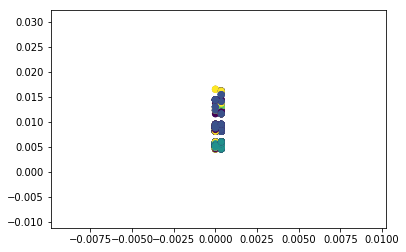

Time: 0.9554281234741211 seconds 
Comparing k-means clusters against the data:
author_id  1340343  1383289  1492818  1558100  1703038  1846741  1874629  \
row_0                                                                      
0                0       23        1        1        6        0        0   
1                0        0        0       11       11        2        0   
2               63       58        0        0        0        0       15   
3                0        0        0        0        0        0        1   
4                1        6        3        0        8        0        1   

author_id  2460557  2556543  2579472   ...    4275352  4287988  4295475  \
row_0                                  ...                                
0                9        0        1   ...          2        3        2   
1                0        0       12   ...          3        1        0   
2               26       22        0   ...          0        0        0   
3            

In [117]:
start = time()
# Calculate predicted values.
y_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X_train_norm)

# Plot the solution.
plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=y_pred)
plt.show()

print('Time: {} seconds '.format(time()-start))
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train))

This looks pretty good, at most an author is spread across 3 clusters, with 1 or 2 being the average. Let's try another amount of clusters to see if performance can be improved. I tried 2 clusters already and it was less effective.

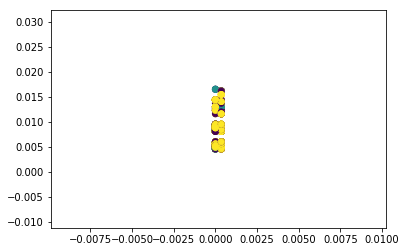

Time: 0.7545499801635742 seconds 
Comparing k-means clusters against the data:
author_id  1340343  1383289  1492818  1558100  1703038  1846741  1874629  \
row_0                                                                      
0                0       23        2        1        7        0        0   
1                1        4        2        0        6        0        2   
2               63       60        0       11       12        2       15   

author_id  2460557  2556543  2579472   ...    4275352  4287988  4295475  \
row_0                                  ...                                
0               11        0        1   ...          3        2        3   
1                2        0        1   ...          1        1        0   
2               27       22       12   ...          2        2        0   

author_id  4304499  4309214  4323836  511887  732730  828046  880688  
row_0                                                                 
0                0    

In [118]:
start = time()
# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_train_norm)

#km = KMeans(n_clusters=num_clusters)

# Plot the solution.
plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=y_pred)
plt.show()

print('Time: {} seconds '.format(time()-start))
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train))

# going to add the info back into the dataframe later
kmeans_clusters = y_pred

3 clusters seems pretty comparable to 5. Let's try one more value of n.

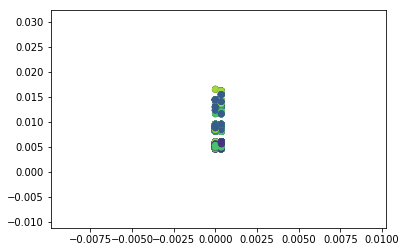

Time: 0.8064920902252197 seconds 
Comparing k-means clusters against the data:
author_id  1340343  1383289  1492818  1558100  1703038  1846741  1874629  \
row_0                                                                      
0                1        2        1        0        6        0        1   
1               63       50        0        0        0        0       15   
2                0        0        0        4       11        2        0   
3                0       22        0        0        0        0        0   
4                0        0        0        0        0        0        1   
5                0       13        0        8        2        0        0   
6                0        0        3        0        6        0        0   
7                0        0        0        0        0        0        0   

author_id  2460557  2556543  2579472   ...    4275352  4287988  4295475  \
row_0                                  ...                                
0         

In [119]:

start = time()
# Calculate predicted values.
y_pred = KMeans(n_clusters=8, random_state=42).fit_predict(X_train_norm)

# Plot the solution.
plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=y_pred)
plt.show()

print('Time: {} seconds '.format(time()-start))
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train))

8 clusters looks a little bit better because the authors for the most part are only spread across 1 or 2 clusters. Let's try mean shift and then move on with whichever is better -  kmeans with 8 clusters, or meanshift.

In [120]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_norm, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 2


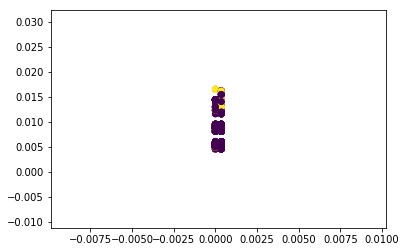

Comparing the assigned categories to the ones in the data:
col_0       0   1
author_id        
1340343    63   1
1383289    82   5
1492818     1   3
1558100    12   0
1703038    18   7
1846741     2   0
1874629    15   2
2460557    38   2
2556543    22   0
2579472    13   1
2874698    27  14
2879658    39  13
2898040     2   3
3059270     2   0
3060073     7   0


In [121]:
plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels).head(15))

This is not really better than kmeans with 8 clusters, from a quick glance.

In [122]:
clusters = ms.labels_.tolist()

In [123]:
print(len(clusters), set(clusters))

2136 {0, 1}


In [124]:
# put the clusters genereated from the Mean shift algorithm into the dataframe so we
# can analyze the clusters a little better
X_train['cluster'] = clusters

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [125]:

X_train['kmeans_cluster'] = kmeans_clusters

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [126]:
X_train.head()

,gender,age,month,day,year,industry_Accounting,industry_Advertising,industry_Architecture,industry_Arts,industry_Biotech,...,man,long,2,keep,these,lot,girl,read,cluster,kmeans_cluster
2671,1,27,7,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
379,1,46,8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1555,1,15,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,0,2
1190,0,15,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
1486,1,24,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,2


In [127]:
df.head()

,author_id,gender,age,post,parsed,month,day,year,industry_Accounting,industry_Advertising,...,play,two,man,long,2,keep,these,lot,girl,read
0,3537375,1,23,"It was going to be a boring, depressing (See b...","(It, was, going, to, be, a, boring, ,, depress...",6,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1
1,3537375,1,23,It seems that RIAA has once again cranked up t...,"(It, seems, that, RIAA, has, once, again, cran...",6,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3537375,1,23,Am I the only one who'd like to know what the ...,"(Am, I, the, only, one, who, 'd, like, to, kno...",6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3537375,1,23,"As the link will show, the number one selling ...","(As, the, link, will, show, ,, the, number, on...",6,0,0,0,0,...,3,0,0,0,1,1,1,0,0,1
4,3537375,1,23,urlLink Supreme Court Ruling The Court nicely ...,"(urlLink, Supreme, Court, Ruling, The, Court, ...",6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Part 4 - Features and models

I'm going to generate some more features using unsupervised techniques and then try to use some models.

In [128]:
# ok so recap, X_train is the X_train withOUT normalization 

X_train.head(3)

,gender,age,month,day,year,industry_Accounting,industry_Advertising,industry_Architecture,industry_Arts,industry_Biotech,...,man,long,2,keep,these,lot,girl,read,cluster,kmeans_cluster
2671,1,27,7,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
379,1,46,8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1555,1,15,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,0,2


###  tf-idf  (vectors for each post)

We already got a single span vector with the supervised learning technique, but I'll also try it using an unsupervised learning technique.

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(max_df=0.75, # drop words that occur in more than 75 percent of the paragraphs
                             min_df=5, # only use words that appear at least n times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
lines_tfidf=vectorizer.fit_transform(df['post'])
print("Number of features: %d" % lines_tfidf.get_shape()[1])

# inititally tried model with parameters: max_df 0.75, min_df 10, # of features was 187

Number of features: 5653


In [130]:
print(lines_tfidf.shape)

(2848, 5653)


In [131]:
terms = vectorizer.get_feature_names()

In [132]:
lines_csr = lines_tfidf.tocsr()

In [133]:
#number of paragraphs
n = lines_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*lines_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = lines_csr[i, j]

In [134]:
#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was
# present once in that sentence.
for i in range(3):
    print('Original sentence:', df.loc[i,'post'])
    print('Tf_idf vector:', tfidf_bypara[i])

Original sentence: It was going to be a boring, depressing (See below) rather sleep deprived Friday until I read that story. In other news, my Handspring Treo 270 crapped out....again. On to the third device, the second one lasted barely 3 months. My phone tripped into a spectacular death this morning with a plethora of software and hardware failures: 1. call waiting ceased to work 2. battery refused to hold a charge 3. handsfree crapped out 4. voice quality had deteriorated significantly (from the less than stellar quality it had when it was new) 5. dropped calls galore and bad RF performance. I must admit I had low expectations for Handspring's build quality as their reputation on web boards was less than stellar. But this Treo device has exceeded my wildest dreams, more accurately my wildest nightmares. I give the new (who am I kidding?)..... refurbished device 2 months max before it kicks the bucket. I thought paying $50 for the device was a bargain, in reality it seems that I have

In [137]:
 # dimension reduction
    
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 4931 to the number below.
svd= TruncatedSVD(1500)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
lines_lsa = lsa.fit_transform(lines_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(lines_lsa, #index=df['post']
                               )
#for i in range(5):
#    print('Component {}:'.format(i))
#    print(paras_by_component.loc[:50,i].sort_values(ascending=False)[0:5])   

Percent variance captured by all components: 90.65913848608426


In [138]:
paras_by_component.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,0.017638,0.108386,-0.062508,-0.031602,0.041406,0.028374,0.033221,-0.054175,0.006604,-0.014231,...,0.008533,-0.001164,0.014098,0.004835,-0.016246,0.004579,0.009575,0.000872,0.015124,-0.014570
1,0.008643,0.064058,-0.041346,0.023336,-0.004799,0.024753,0.055289,-0.036965,-0.026980,0.025389,...,0.019090,-0.000465,0.000638,0.011132,-0.012936,-0.001847,-0.010096,0.014757,0.006880,-0.014597
2,0.010861,0.098842,0.027477,0.043451,-0.043193,0.013637,0.050813,0.048954,-0.041930,-0.000009,...,0.012537,-0.023603,-0.004512,-0.016131,-0.009711,0.003818,-0.004550,-0.010593,-0.004528,0.008739


In [139]:
# add the components back into the dataframe as features

df = df.reset_index(drop=True)
paras_by_component = paras_by_component.reset_index(drop=True)

df = df.join(paras_by_component)

df.head()

,author_id,gender,age,post,parsed,month,day,year,industry_Accounting,industry_Advertising,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,3537375,1,23,"It was going to be a boring, depressing (See b...","(It, was, going, to, be, a, boring, ,, depress...",6,0,0,0,0,...,0.008533,-0.001164,0.014098,0.004835,-0.016246,0.004579,0.009575,0.000872,0.015124,-0.014570
1,3537375,1,23,It seems that RIAA has once again cranked up t...,"(It, seems, that, RIAA, has, once, again, cran...",6,0,2,0,0,...,0.019090,-0.000465,0.000638,0.011132,-0.012936,-0.001847,-0.010096,0.014757,0.006880,-0.014597
2,3537375,1,23,Am I the only one who'd like to know what the ...,"(Am, I, the, only, one, who, 'd, like, to, kno...",6,0,1,0,0,...,0.012537,-0.023603,-0.004512,-0.016131,-0.009711,0.003818,-0.004550,-0.010593,-0.004528,0.008739
3,3537375,1,23,"As the link will show, the number one selling ...","(As, the, link, will, show, ,, the, number, on...",6,0,0,0,0,...,0.005157,0.006150,0.012663,0.004732,-0.017302,-0.007846,-0.019639,-0.006088,0.011755,0.017238
4,3537375,1,23,urlLink Supreme Court Ruling The Court nicely ...,"(urlLink, Supreme, Court, Ruling, The, Court, ...",6,0,0,0,0,...,0.009192,0.024520,-0.008543,-0.004394,-0.028703,0.023151,0.017935,0.001490,-0.013207,-0.001788


Document similarity

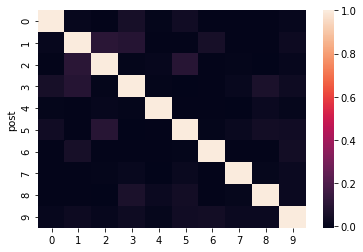

Key:
0 It was going to be a boring, depressing (See below) rather sleep deprived Friday until I r
1 It seems that RIAA has once again cranked up the P2P law suit machine. Given their recent 
2 Am I the only one who'd like to know what the first year rankings are? They are only mildl
3 As the link will show, the number one selling album in the U.S. is the new Velvet Revolver
4 urlLink Supreme Court Ruling The Court nicely upheld the pledge without actually upholding
5 It has been a scorcher of a week, it has been hot and humid. As an engineer, I work best i
6 NOTHING, on the front page, not even a blurb. not even a 4 font by line. Hmmm, interesting
7 President George W. Bush: This is a sad hour in the life of America. A great American life
8 Productivity has ground to a halt for jack today. The most useful thing I have done today 
9 Hi everybody, Ok, I would be remiss not to mention the plague of biblical proportions that


In [144]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(lines_lsa) * np.asmatrix(lines_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=df['post']).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i][:90])

In [145]:
print(similarity.shape, df.shape)


(2848, 2848) (2848, 1700)


In [146]:
df.iloc[:3,:5]

,author_id,gender,age,post,parsed
0,3537375,1,23,"It was going to be a boring, depressing (See b...","(It, was, going, to, be, a, boring, ,, depress..."
1,3537375,1,23,It seems that RIAA has once again cranked up t...,"(It, seems, that, RIAA, has, once, again, cran..."
2,3537375,1,23,Am I the only one who'd like to know what the ...,"(Am, I, the, only, one, who, 'd, like, to, kno..."


In [148]:
# add the features back to the training and test sets

X_train = X_train.join(df.iloc[:,200:])
X_test = X_test.join(df.iloc[:,200:])

## models

a - gradient boosting

In [149]:
from sklearn.model_selection import cross_val_score

In [150]:
from sklearn import ensemble

In [151]:
#X_train_smaller = withbin.drop(['post','parsed'], 1)
#y_train

# training on smaller portions of X_train so I can test it on itself

X_train_smaller, X_test_smaller, y_train_smaller, y_test_smaller = train_test_split(X_train,
                                                                y_train, test_size=.25)

In [152]:
# with defaults - Training set score: 0.00846262341325811
#Test set score: 0.004739336492890996

clf = ensemble.GradientBoostingClassifier(n_estimators=200)


In [153]:
clf.fit(X_train_smaller, y_train_smaller)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [154]:
training_score = clf.score(X_train_smaller, y_train_smaller)

In [155]:
# need to get the clusters before i can run this
testing_score = clf.score(X_test_smaller, y_test_smaller)


In [156]:
print('Training set score:', training_score)
print('\nTest set score:', testing_score)

Training set score: 0.9993757802746567

Test set score: 0.5749063670411985


In [157]:
scores = cross_val_score(clf, X_train,y_train,cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.59 (+/- 0.11)


In [158]:
scores = cross_val_score(clf,X_train_smaller,y_train_smaller,cv=5)

print("Accuracy: %0.2f (+/- %0.2f)"% (scores.mean(), scores.std() *2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.55 (+/- 0.09)


b - logistic regression

In [159]:
from sklearn.linear_model import LogisticRegression

In [160]:
lr = LogisticRegression()

train = lr.fit(X_train_smaller, y_train_smaller)


In [161]:
lr.score(X_train_smaller,y_train_smaller)

0.9975031210986267

In [162]:
lr.score(X_test_smaller, y_test_smaller)

0.7097378277153558

In [163]:
scores = cross_val_score(lr, X_test_smaller,y_test_smaller,cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.67 (+/- 0.39)


c. random forest

In [164]:
rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train_smaller,y_train_smaller)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [165]:
train = rfc.score(X_train_smaller,y_train_smaller)

In [166]:
test = rfc.score(X_test_smaller,y_test_smaller)

In [167]:
print('Training set score:', train)
print('\nTest set score:', test)

Training set score: 1.0

Test set score: 0.4943820224719101


In [168]:
scores = cross_val_score(rfc, X_test_smaller,y_test_smaller,cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.45 (+/- 0.40)


# Part 5 - back to holdout group

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

### clustering on holdout group

first i need to normalize the data

In [169]:
X_test_norm = normalize(X_test)

K Means

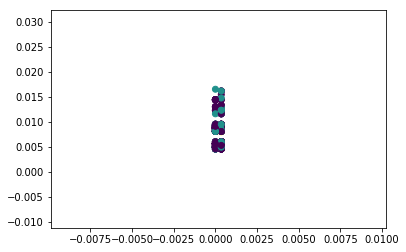

Time: 0.8692121505737305 seconds 
Comparing k-means clusters against the data:
author_id  1340343  1383289  1492818  1558100  1703038  1846741  1874629  \
row_0                                                                      
0               20       29        0        4        6        1        4   
1                0       11        1        0        2        0        0   
2                0        1        0        0        0        0        0   

author_id  2460557  2556543  2579472   ...    4251949  4275352  4287988  \
row_0                                  ...                                
0               11        6        2   ...          0        2        1   
1                0        0        0   ...          1        0        0   
2                0        0        0   ...          0        0        0   

author_id  4295475  4304499  4309214  511887  732730  828046  880688  
row_0                                                                 
0                0    

In [170]:
start = time()
# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_test_norm)

# Plot the solution.
plt.scatter(X_test_norm[:, 0], X_test_norm[:, 1], c=y_pred)
plt.show()

print('Time: {} seconds '.format(time()-start))
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_test))

# going to add the info back into the dataframe later
kmeans_clusters = y_pred

Mean shift

Number of estimated clusters: 1


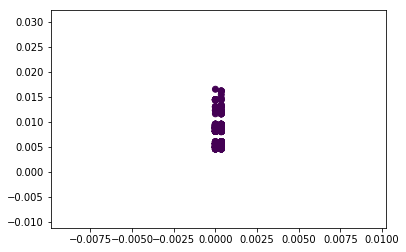

Comparing the assigned categories to the ones in the data:
col_0       0
author_id    
1340343    20
1383289    41
1492818     1
1558100     4
1703038     8
1846741     1
1874629     4
2460557    11
2556543     6
2579472     2
2874698    17
2879658    19
2898040     2
3060073     1
3081158    12


In [171]:
ms.fit(X_test_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

plt.scatter(X_test_norm[:, 0], X_test_norm[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_test,labels).head(15))


In [172]:
clusters = ms.labels_.tolist()

In [173]:
# add the clusters as features for the next step

X_test['cluster'] = clusters
X_test['kmeans_cluster'] = kmeans_clusters

## modelling

same steps to add the features, then using the previously fit models on the holdout data to see how it works

In [174]:
#X_test.columns.values

The model below won't work because a column is missing. Let's see what it is and add it if that is feasible.

In [175]:
#test_cols = X_test_bin.columns.values
#with_cols = withbin.columns.values

#for col in with_cols:
#    if col not in test_cols:
#        print(col)

In [176]:
# X_test_bin['industry_Advertising'] = 0

gradient boosting


In [177]:
new_testing_score = clf.score(X_test, y_test)

print('Holdout score:', new_testing_score)

Holdout score: 0.49719101123595505


In [178]:
scores_gb = cross_val_score(clf,X_test,y_test,cv=10)

print("Accuracy: %0.2f (+/-  %0.2f)" % (scores_gb.mean(), scores_gb.std()*2 ))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.50 (+/-  0.31)


logistic regression

In [179]:
lr.score(X_test, y_test)

0.6952247191011236

In [180]:
lr_cv = cross_val_score(lr,X_test,y_test,cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (lr_cv.mean(), lr_cv.std() * 2 ))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.66 (+/- 0.33)


random forest

In [181]:
rfc.score(X_test,y_test)

0.3497191011235955

In [182]:
scores = cross_val_score(rfc, X_test,y_test,cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.48 (+/- 0.34)


<hr width="50%" />

## Summary

The clusters generated on the test group seem the most different when comparing the test group to the training group, possibly because the amount of data is so much less, and as a result the variance and distinct features are also less.

The models are not especially great for both the training and testing groups. It looks like they are either overfit or have a lack of accuracy that is concerning and makes their usefulness questionable.

When comparing clustering to modeling, in terms of classifying these texts, it appears like modelling is better for isolating specific features and would be good if you had an idea of what specific features would be most useful to generate, or if you had the patience to do that.

Clustering on the other hand was approximately as accurate but didn't require knowing much about the contents of the posts in order to organize them by author.

In consideration of that, I think in this case clustering was the best method, because it didn't require knowledge of the contents of the text. However, I imagine if someone did have an idea of the contexts of the text, they would be able to generate more specifically targeted features, and potentially in that case, modelling could perform significantly better.

